<h1 align="center">Style Transfer</h1> 

In [1]:
from PIL import Image
import lovely_tensors as lt
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt

from ldm.modules.encoders.modules import FrozenOpenCLIPEmbedder
from ldm.modules.diffusionmodules.openaimodel import UNetModel
from ldm.models.autoencoder import AutoencoderKL

from helper import ForwardDiffusionProcessor, X2imgs, imgs2X

lt.monkey_patch()

/home/chris/miniconda3/envs/stable-diffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.


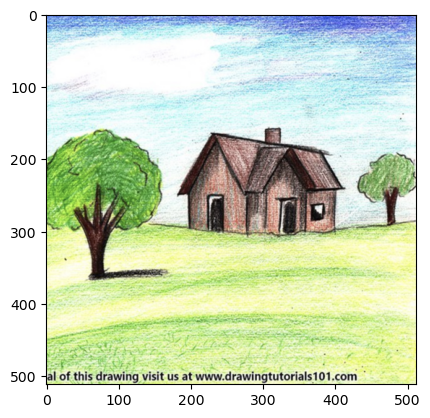

In [2]:
# open the image drawing.jpg and convert it into a numpy array
seed_img_path = "data/drawing.jpg"
# seed_img_path = "data/drawing2.jpg"
# seed_img_path = "data/scetch.jpg"

seed_img = np.array(Image.open(seed_img_path).resize((512,512)))
plt.imshow(seed_img)
plt.show()

In [3]:
# laod the weights

ckpt = "v2-1_512-ema-pruned.ckpt"
state_dict = torch.load(ckpt, map_location="cpu")["state_dict"]

state_dict_vae = {}
state_dict_unet = {}
state_dict_clip_embedder = {}

for k, v in state_dict.items():
    if k.startswith("first_stage_model."):
        state_dict_vae[k.replace("first_stage_model.", "")] = v
    elif k.startswith("model.diffusion_model."):
        state_dict_unet[k.replace("model.diffusion_model.", "")] = v
    elif k.startswith("cond_stage_model."):
        state_dict_clip_embedder[k.replace("cond_stage_model.", "")] = v
    else:
        pass

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the parameters
config_path = "../stablediffusion-repo/configs/stable-diffusion/v2-inference.yaml"
cfg = OmegaConf.load(config_path)

# load the variational autoencoder
vae = AutoencoderKL(**cfg.model.params.first_stage_config.params)
vae.load_state_dict(state_dict_vae, strict=True)
vae.to(device)
vae.eval()

# load the ddpm (denoising diffusion probabilistic model)
unet = UNetModel(**cfg.model.params.unet_config.params)
unet.load_state_dict(state_dict_unet, strict=True)
unet.to(device)
unet.eval()

# load the clip embedder
clip_embedder = FrozenOpenCLIPEmbedder(**cfg.model.params.cond_stage_config.params)
clip_embedder.load_state_dict(state_dict_clip_embedder, strict=True)
clip_embedder.to(device)
clip_embedder.eval()

pass

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


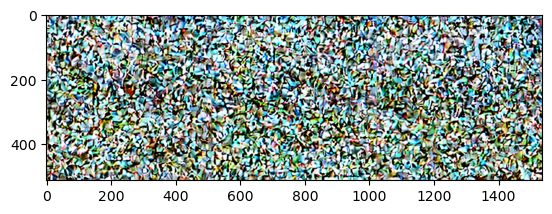

In [4]:
# Parameters
batch_size = 3
ts_start = 800
prompt = "Oil painting of a house"
guidance_scale = 7
n_steps = 100

# create a diffusion latent vector
fdp = ForwardDiffusionProcessor()

X = imgs2X(seed_img[np.newaxis, ...], device)
with torch.no_grad(), torch.cuda.amp.autocast():
    
    # encode
    posterior = vae.encode(X)
    Z_drawing = posterior.sample()
    
    # rescale the latent vector
    Z_drawing = Z_drawing * cfg.model.params.scale_factor

    # duplicate     
    Z_drawing = torch.cat([Z_drawing] * batch_size)

    # add noise
    Z0 = fdp.defuse_sample(Z_drawing.cpu().numpy(), ts_start)
    Z0 = torch.from_numpy(Z0.astype(np.float32)).to(device)

    # reconstruct
    X_tilde = vae.decode(Z0 / cfg.model.params.scale_factor)
    imgs_reconstructed = X2imgs(X_tilde)

plt.imshow(np.hstack(imgs_reconstructed))
plt.show()

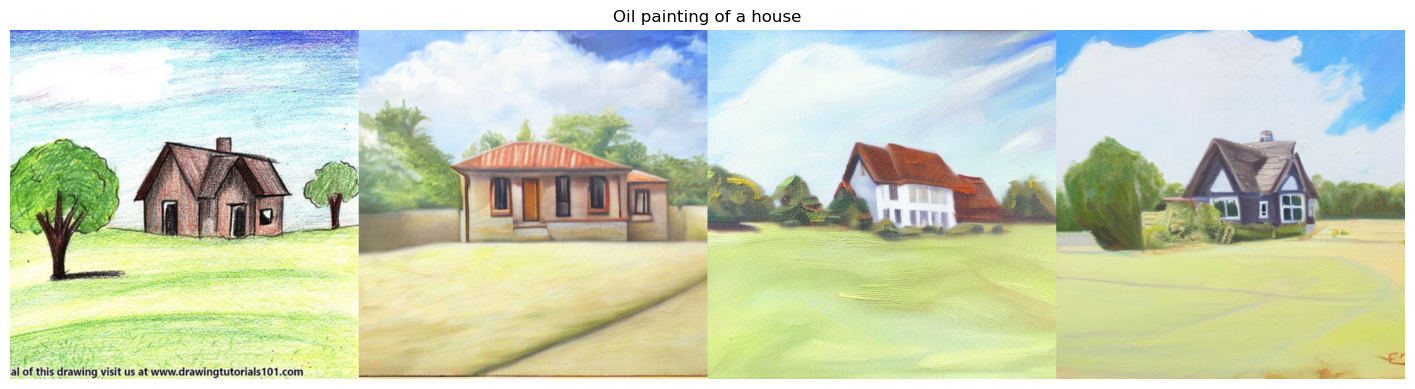

In [5]:
# Generate the prompt embedding. Because we are using classifier-free guidance,
# we need to generate two embedding, i.e. the embedding of our prompt and the
# embedding of the unconditioned prompt.
with torch.no_grad():
    C = clip_embedder(batch_size * [prompt])
    C_unconditioned = clip_embedder(batch_size * [""])

# Generate the timesteps.
timesteps = fdp.get_timesteps(n_steps)

# Denoise the image.
Z = Z0
Z_evo = []
with torch.no_grad(), torch.cuda.amp.autocast():    

    # for ts in timesteps[::-1]:
    for i in reversed(range(n_steps)):

        ts = timesteps[i]
        ts_prev = timesteps[i - 1] if i > 0 else ts        

        if ts > ts_start:
            continue

        print(f"{i:>4} | ts={ts:<3} -> ts_prev={ts_prev:<3}", end="\r")

        # Encode the timestep.
        TS = torch.full((batch_size,), ts, device=device, dtype=torch.long)

        # Estimate the noise on the image. We do this twice, once conditioned on
        # the prompt and once unconditioned.
        EPS, EPS_unconditioned = unet(
            torch.cat([Z] * 2), 
            torch.cat([TS] * 2), 
            torch.cat([C, C_unconditioned])
            ).chunk(2)

        # Combine the predicted conditioned and unconditioned noise to guide the
        # denoising process.
        EPS = EPS_unconditioned + guidance_scale * (EPS - EPS_unconditioned)

        # Calculate the denoised image. The corresponding formula can be found
        # in the following paper or in the blog post from Lilian Weng:
        # - https://arxiv.org/abs/2010.02502
        # - https://lilianweng.github.io/posts/2021-07-11-diffusion-models/    
        alpha_bar = torch.full((batch_size, 1, 1, 1), fdp.get_alpha_bar(ts), device=device)
        alpha_bar_prev = torch.full((batch_size, 1, 1, 1), fdp.get_alpha_bar(ts_prev), device=device)
        Z = alpha_bar_prev.sqrt() * (Z - (1 - alpha_bar).sqrt()*EPS) / alpha_bar.sqrt() + (1-alpha_bar_prev).sqrt() * EPS
        Z_evo.append(Z)

    # Decode the latent vector to get the final image.      
    Z_ = 1.0 / cfg.model.params.scale_factor * Z
    X = vae.decode(Z_)
    imgs = X2imgs(X)    
    

plt.figure(figsize=(batch_size*6, 6))
seed_and_imgs = np.vstack([seed_img[np.newaxis, ...], imgs])
plt.imshow(np.hstack(seed_and_imgs))
plt.axis("off")
plt.title(prompt)
plt.show()